## Notebook info

Authors:    Leone, Riccardo (RL)

Notes:     
- Main script to analyze the single-subject fitting simulations results of the petTOAD study.

Comments:
- []

Sources: 
- 

Last edit:  2023-12-13

## Imports

In [333]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from statannotations.Annotator import Annotator
from petTOAD_setup import *
from petTOAD_parameter_setup import *

## Directories

In [334]:
SIM_DIR = RES_DIR / "final_simulations_log_2023-11-23"
SIM_GROUP_DIR = RES_DIR / "final_simulations"
A_DIR = SIM_DIR / "a-weight_ws_-0.1-0.0_bs_-0.05-0.0"
A_RAND_DIR = SIM_DIR / "a-weight_ws_-0.1-0.0_bs_-0.05-0.0_random"
G_DIR = SIM_DIR / "G-weight_ws_-1.0-0.0_bs_-0.5-0.0"
G_RAND_DIR = SIM_DIR / "G-weight_ws_-1.0-0.0_bs_-0.5-0.0_random"
SC_DIR = SIM_DIR / "sc_disconn_old"
SC_RAND_DIR = SIM_DIR / "sc_disconn_random_old"
HET_DIR = SIM_DIR / "heterogeneous_ws_-0.1-0.0_bs_-0.05-0.0"
HET_RAND_DIR = SIM_DIR / "heterogeneous_ws_-0.1-0.0_bs_-0.05-0.0_random"
FIG_DIR = RES_DIR / "Figures"
TBL_DIR = RES_DIR / "Tables"

for dir in [TBL_DIR, FIG_DIR]:
    if not Path.exists(dir):
        Path.mkdir(dir)

In [335]:
# Change if you used another a for the CU WMH group!
a = -0.02
df_best_G = pd.read_csv(SIM_GROUP_DIR / "group-CN-no-WMH_desc-best-G.csv", index_col=0)
best_G = float(df_best_G["K_gl"])

## Functions

In [336]:
def gather_df_results(df_demo, list_subjs, wmh_dict, model, folder, random=False):
    # def convert_to_list(s, fc):
    #     if fc:
    #         return [float(x) for x in s.strip("[]").split(",")]
    #     else:
    #         return [float(x) for x in s.strip("[]").split()]

    df_big = pd.DataFrame()
    #df_big_max = pd.DataFrame()
    for subj in list_subjs:
        df = pd.read_csv(folder / f"sub-{subj}_df_results_{model}.csv", index_col=0)
        if model in ["homogeneous_a-weight", "homogeneous_G-weight"]:
            df["wmh_load"] = wmh_dict[subj]
            df["model_type"] = model[:-7]

        elif model == "disconn":
            df["model_type"] = "disconnectivity"
            # # The sc disconnectivity is saved as a string instead than a list for some reason.. so we convert it to how it's supposed to be
            # w = df["w"].apply(convert_to_list, fc=False)
            # phfcd = df["phfcd_ks"].apply(convert_to_list, fc=False)
            # fc = df["fc_pearson"].apply(convert_to_list, fc=True)
            # df = pd.concat([w, fc, phfcd], axis=1).explode(
            #     column=["w", "fc_pearson", "phfcd_ks"]
            # )
            # df["fc_pearson"] = pd.to_numeric(df["fc_pearson"])
            # df["phfcd_ks"] = pd.to_numeric(df["phfcd_ks"])
            # df["model_type"] = "disconnectivity"
            # df["random"] = "random"

        elif model == "heterogeneous":
            df["model_type"] = model
          
        if not random:
            df["random"] = "not_random"
        else:
            df["random"] = "random"

        df["PTID"] = subj
        df["phfcd_ks"] = 1 - df["phfcd_ks"]
        df = pd.merge(df, df_demo[["PTID", "Group_bin_Fazekas", "WMH_bin"]], on="PTID")
        df_big = pd.concat([df_big, df], ignore_index=True)

    return df_big


def create_df_max_rand(df_max, df_rand_big, model_type):
    """This function looks for the corresponding values of b and w in the model where wmh load was randomly shuffled"""
    df_max_rand = pd.DataFrame()

    if model_type == "disconnectivity":
        for row in df_max.iterrows():
            ptid = row[1]["PTID"]
            w = row[1]["w"]
            df_max_rand = pd.concat(
                [
                    df_max_rand,
                    df_rand_big[
                        (df_rand_big["PTID"] == ptid) & (df_rand_big["w"] == w)
                    ],
                ]
            )
            df_max_rand["model_type"] = model_type
            df_max_rand["random"] = "random"

    else:
        for row in df_max.iterrows():
            ptid = row[1]["PTID"]
            w = row[1]["w"]
            b = row[1]["b"]
            df_max_rand = pd.concat(
                [
                    df_max_rand,
                    df_rand_big[
                        (df_rand_big["PTID"] == ptid)
                        & (df_rand_big["w"] == w)
                        & (df_rand_big["b"] == b)
                    ],
                ]
            )
            df_max_rand["model_type"] = model_type
            df_max_rand["random"] = "random"

    return df_max_rand


def create_merged_df_rand(list_tuples):
    """Creates the df with random fits for all models"""
    # create tuples
    df_max_rand = pd.DataFrame()
    for tp in list_tuples:
        df_max_rand_model = create_df_max_rand(tp[0], tp[1], tp[2])
        df_max_rand = pd.concat([df_max_rand, df_max_rand_model])
    return df_max_rand


def save_annotator_results_raw(
    groupname: str,
    data_type: str,
    model_type: str,
    results: Annotator.apply_and_annotate,
    comparing_what: str,
):
    """
    Save annotator results in raw format to a CSV file.

    Parameters:
    - groupname (str): The name of the group or "all" for all groups.
    - data_type (str): The type of data being compared (simulated or empirical).
    - model_type (str): The type of model used for comparison.
    - results (list): List of results objects containing data for each comparison from statannotations.Annotator.apply_and_annotate()
    - comparing_what (str): The aspect of comparison (e.g., integration, segregation).

    Returns:
    None

    This function takes in the specified parameters and extracts relevant information
    from the results to create a DataFrame. It then saves this DataFrame to a CSV file.
    The CSV file is named based on the provided parameters and is stored in the SIM_DIR
    directory.

    Example Usage:
    save_annotator_results_raw("MCI_WMH", "simulated", "homogeneous_G", results, "integration")
    """

    dict_res = {}
    for res in results:
        dict_key = res.data.group1 + "_" + res.data.group2
        dict_res[dict_key] = res.data.formatted_output.split(",")[1]
    test_name = res.data.formatted_output.split(",")[0]
    df = pd.DataFrame(dict_res, index=[test_name]).T
    data_type = "simulated-" + data_type
    df.to_csv(
        SIM_DIR
        / f"group-{groupname}_data-{data_type}_model-{model_type}_desc-df-{comparing_what}-comparison.csv"
    )


def plot_obs(df, groupname, max_or_avg, obs, ax):
    """
    This function plots the annotations for statistical comparisons between groups
    """
    df["phfcd_ks"] = pd.to_numeric(df["phfcd_ks"], errors="coerce")
    order = [
        "baseline",
        "homogeneous_a",
        "homogeneous_G",
        "heterogeneous",
        "disconnectivity",
    ]
    ordered_names = ["Base", "Homog. a", "Homog. G", "Heterog.", "Disconn."]
    pairs = [
        ("baseline", "homogeneous_a"),
        ("baseline", "homogeneous_G"),
        ("baseline", "heterogeneous"),
        ("baseline", "disconnectivity"),

    ]
    f = sns.boxplot(data=df, x="model_type", y=obs, ax=ax)
    ax.set_xticks(
        [0, 1, 2, 3, 4], ordered_names
    )  # Change this when adding hetero /disconn
    ax.set_xlabel("Model type")
    ax.set_ylim(0.43, .98)
    annotator = Annotator(f, pairs, data=df, x="model_type", y=obs, order=order)
    # Choose the type of statistical test to perform
    annotator.configure(
        test="Wilcoxon",
        text_format="star",
        loc="inside",
        verbose=1,
        hide_non_significant=True,
        comparisons_correction="BH",
        line_height=0.0,
    )
    _, results = annotator.apply_test().annotate(line_offset_to_group=0.02)
    save_annotator_results_raw(groupname, max_or_avg, "all", results, "fitting")


def plot_random_comparison(df, obs, ax):
    """
    This function is for plotting the comparison between the model results achieved in CN and MCI with the same model
    """
    df["phfcd_ks"] = pd.to_numeric(df["phfcd_ks"], errors="coerce")
    df = df[
        df["model_type"].isin(
            ["homogeneous_a", "homogeneous_G", "heterogeneous", "disconnectivity"]
        )
    ]
    order = ["homogeneous_a", "homogeneous_G", "heterogeneous", "disconnectivity"]
    ordered_names = ["Homog. a", "Homog. G", "Heterog.", "Disconn."]
    pairs = [
        (("homogeneous_a", "random"), ("homogeneous_a", "not_random")),
        (("homogeneous_G", "random"), ("homogeneous_G", "not_random")),
        (("heterogeneous", "random"), ("heterogeneous", "not_random")),
        (("disconnectivity", "random"), ("disconnectivity", "not_random")),
    ]

    # This is a dictionary of arguments that are passed into the function inside map_dataframe
    kwargs = {
        "plot_params": {  # this takes what normally goes into sns.barplot etc.
            "x": "model_type",
            "y": f"{obs}",
            "hue": "random",
            "hue_order": ["random", "not_random"],
            "order": order,
        },
        "annotation_func": "apply_test",
        "configuration": {
            "test": "Wilcoxon",
            "line_height": 0,
            "hide_non_significant": True,
        },  # this takes what normally goes into anmot.configure
        "plot": "boxplot",
        # If you want to add the figure into a subplot...
        "ax": ax,
    }

    ant = Annotator(None, pairs)
    # We create a FacetGrid and pass the dataframe that we want to use to later apply our functions (plotting the comparisons between groups)
    g1 = sns.FacetGrid(df, aspect=1.5, height=4)
    # map_dataframe accepts a function, which it then applies to the dataframe that is previously passed in the FacetGrid. It also accepts kwargs which
    # are passed inside the function
    g1.map_dataframe(ant.plot_and_annotate_facets, **kwargs)
    ax.set_xticklabels(ordered_names)
    ax.set_ylabel("1 - KSD")
    ax.set_xlabel("Model type")
    # Create custom legend handles with Patches, IDK a better way...
    legend_handles = [
        Patch(facecolor="white", edgecolor="black"),  # Box for "Random"
        Patch(facecolor="tab:blue", edgecolor="black"),  # Box for "Not random"
    ]
    ax.legend(
        handles=legend_handles, labels=["Random", "Not random"], loc="lower right"
    )
    plt.close()


def write_figure_letters(axs):
    axs = axs.flat
    for n, ax in enumerate(axs):
        ax.text(
            -0.1,
            1.0,
            string.ascii_uppercase[n],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )


def plot_cn_mci_comparison(
    obs, df_compare_groups, ax
):  # (obs, axs) if you want subplots
    """
    This function is for plotting the comparison between the model results achieved in CN and MCI with the same model
    """
    df_compare_groups["phfcd_ks"] = pd.to_numeric(
        df_compare_groups["phfcd_ks"], errors="coerce"
    )
    ordered_names = ["Base", "Homog. a", "Homog. G", "Heterog.", "Disconn."]
    pairs = [
        (("baseline", "CN_WMH"), ("baseline", "MCI_WMH")),
        (("homogeneous_a", "CN_WMH"), ("homogeneous_a", "MCI_WMH")),
        (("homogeneous_G", "CN_WMH"), ("homogeneous_G", "MCI_WMH")),
        (("heterogeneous", "CN_WMH"), ("heterogeneous", "MCI_WMH")),
        (("disconnectivity", "CN_WMH"), ("disconnectivity", "MCI_WMH")),
    ]

    # This is a dictionary of arguments that are passed into the function inside map_dataframe
    kwargs = {
        "plot_params": {  # this takes what normally goes into sns.barplot etc.
            "x": "model_type",
            "y": f"{obs}",
            "hue": "Group_bin_Fazekas",
            # "hue_order": ["CN WMH", "MCI WMH"],
        },
        "annotation_func": "apply_test",
        "configuration": {
            "test": "Mann-Whitney",
            "line_height": 0,
            "hide_non_significant": True,
        },  # this takes what normally goes into ant.configure
        "plot": "boxplot",
        # If you want to add the figure into a subplot...
        "ax": ax,
    }

    ant = Annotator(None, pairs)
    # We create a FacetGrid and pass the dataframe that we want to use to later apply our functions (plotting the comparisons between groups)
    g1 = sns.FacetGrid(df_compare_groups, aspect=1.5, height=4)
    # map_dataframe accepts a function, which it then applies to the dataframe that is previously passed in the FacetGrid. It also accepts kwargs which
    # are passed inside the function
    g1.map_dataframe(ant.plot_and_annotate_facets, **kwargs)
    ax.set_xticklabels(ordered_names)
    ax.set_ylabel("1 - KSD")
    ax.set_xlabel("Model type")
    # Create custom legend handles with Patches, IDK a better way...
    legend_handles = [
        Patch(facecolor="white", edgecolor="black"),  # Box for "Random"
        Patch(facecolor="tab:blue", edgecolor="black"),  # Box for "Not random"
    ]

    ax.legend(handles=legend_handles, labels=["CU WMH", "MCI WMH"])
    plt.close()

# Load all model results

In [337]:
# Load the clinical dataframe with the groupings
df_petTOAD_pre = pd.read_csv(RES_DIR / "df_petTOAD.csv", index_col=0)
df_petTOAD_pre["WMH_bin"] = np.where(
    df_petTOAD_pre["Group_bin_Fazekas"].str.contains("no_WMH"), "no_WMH", "WMH"
)
df_petTOAD = df_petTOAD_pre.copy()

# Start loading the model results df
wmh_log_dict = get_wmh_load_homogeneous_log(subjs_to_sim)
df_a_big = gather_df_results(
    df_petTOAD, subjs_to_sim, wmh_log_dict, "homogeneous_a-weight", A_DIR, random = False
)
df_a_rand_big = gather_df_results(
    df_petTOAD, subjs_to_sim, wmh_log_dict, "homogeneous_a-weight", A_RAND_DIR, random = True
)
df_G_big = gather_df_results(
    df_petTOAD, subjs_to_sim, wmh_log_dict, "homogeneous_G-weight", G_DIR, random = False
)
df_G_rand_big = gather_df_results(
    df_petTOAD, subjs_to_sim, wmh_log_dict, "homogeneous_G-weight", G_RAND_DIR, random = True
)
df_het_big = gather_df_results(
    df_petTOAD, subjs_to_sim, wmh_log_dict, "heterogeneous", HET_DIR, random = False
)
df_het_rand_big = gather_df_results(
    df_petTOAD, subjs_to_sim, wmh_log_dict, "heterogeneous", HET_RAND_DIR, random = True
)
df_disconn_big = gather_df_results(
    df_petTOAD, subjs_to_sim, wmh_log_dict, "disconn", SC_DIR, random = False
)
df_disconn_big["w"] = np.round(df_disconn_big["w"], 2)
df_disconn_rand_big = gather_df_results(
    df_petTOAD, subjs_to_sim, wmh_log_dict, "disconn", SC_RAND_DIR, random = True
)

# The baseline databases is with a = -0.02 and G = 1.98, which is the same as the homogeneous a-weight database when b and w = 0!
df_base = df_a_big[(df_a_big["w"] == 0) & (df_a_big["b"] == 0)].copy()
df_base["model_type"] = "baseline"

# BEST AVERAGE analyses

In [365]:
def annotate_star(tbl):
    """
    This function is just to plot an asterisk at the best heatmap value for better recognition.
    """
    star = tbl.where(tbl == tbl.values.max())
    star = star.replace({np.nan: ""})
    star = star.replace({tbl.values.max(): "*"})
    return star


def create_pivot_tables(df_res):
    # Convert the result df into a pivot table so to plot heatmap
    table_phfcd = pd.pivot_table(
        df_res, values="phfcd_ks", index="b", columns="w"
    ).astype(float)
    return table_phfcd


def plot_save_heatmaps_group(group, table_phfcd, ax):
    """
    This function starts from the results dataframe, converts it into a pivot-table, which is what seaborn need to plot the heatmap.
    It does so both for fc and for phfcd. Also plots and saves the results.
    """

    dict_groupnames = {
        "All": "All",
        "CN_WMH": "CU WMH",
        "MCI_WMH": "MCI WMH",
    }
    sns.heatmap(
        ax=ax,
        data=table_phfcd,
        annot=annotate_star(table_phfcd),
        fmt="",
        annot_kws={"size": 10},
    )
    cbar = ax.collections[0].colorbar
    cbar.set_label("1 - KSD", rotation=270, labelpad=15)
    if group == "disconnectivity":
        ax.set_yticklabels([])  # Remove y-axis tick labels
        ax.set_ylabel("")  # Remove y-axis tick labels
    ax.set_title(dict_groupnames[group])


def plot_save_best_fit_lineplots_group(group, model, df_big, ax, best_b_all):
    """ """

    dict_groupnames = {
        "All": "All",
        "CN_WMH": "CU WMH",
        "MCI_WMH": "MCI WMH",
    }

    if model != "disconnectivity":
        df_big_group = df_big[
            (df_big["Group_bin_Fazekas"] == group) & (df_big["b"] == best_b_all)
        ]
    else:
        df_big_group = df_big[(df_big["Group_bin_Fazekas"] == group)]
    df_big_group_phfcd = df_big_group.groupby("w").describe()["phfcd_ks"]
    ax.plot(df_big_group_phfcd.index, df_big_group_phfcd["mean"])
    ax.fill_between(
        df_big_group_phfcd.index,
        df_big_group_phfcd["mean"] - 1.96 * df_big_group_phfcd["std"],
        df_big_group_phfcd["mean"] + 1.96 * df_big_group_phfcd["std"],
        alpha=0.4,
    )
    ax.set_title(dict_groupnames[group])


def find_best_b_w_group(group, model, df_big, best_b_all=None):
    """
    This function calls the save_plot_results function, which plots and saves a summary heatmap of the mean FC and 1-phFCD across all patients that fall
    into a category (CN or MCI) according to the chosen grouping.

    Args:
        df_petTOAD:
        big_df:
        group:
        random:

    Returns:
        The b and ws associated with
    """
    if model == "disconnectivity":
        if group == "All":
            df = df_big.groupby(["w"]).mean(numeric_only=True)
        else:
            df = (
                df_big[df_big["Group_bin_Fazekas"] == group]
                .groupby(["w"])
                .mean(numeric_only=True)
            )
        best_w = df.iloc[np.argmax(df["phfcd_ks"]), :].name
        tbl_phfcd = df[["phfcd_ks"]].T

        print(f"The best parameters found for {group}, {model}:")
        print(f"w = {best_w}")
        return None, best_w, tbl_phfcd

    else:
        if group == "All":
            df = df_big.groupby(["b", "w"]).mean(numeric_only=True)
            best_b_all = df.iloc[np.argmax(df["phfcd_ks"]), :].name[0]
            best_w = df.iloc[np.argmax(df["phfcd_ks"]), :].name[1]
            tbl_phfcd = create_pivot_tables(df)
            print(f"The best b for group: All and model: {model} is {best_b_all}")
        else:
            df = (
                df_big[df_big["Group_bin_Fazekas"] == group]
                .groupby(["b", "w"])
                .mean(numeric_only=True)
            )
            df_best_row = df.loc[best_b_all, :]
            best_w = df_best_row.iloc[df_best_row["phfcd_ks"].argmax()].name
            tbl_phfcd = create_pivot_tables(df)
    return best_b_all, best_w, tbl_phfcd

The best b for group: All and model: homogeneous_a is 0.0
The best b for group: All and model: homogeneous_G is -0.1
The best b for group: All and model: heterogeneous is 0.0
The best parameters found for All, disconnectivity:
w = -0.46
The best parameters found for CN_WMH, disconnectivity:
w = -0.06
The best parameters found for MCI_WMH, disconnectivity:
w = -0.46


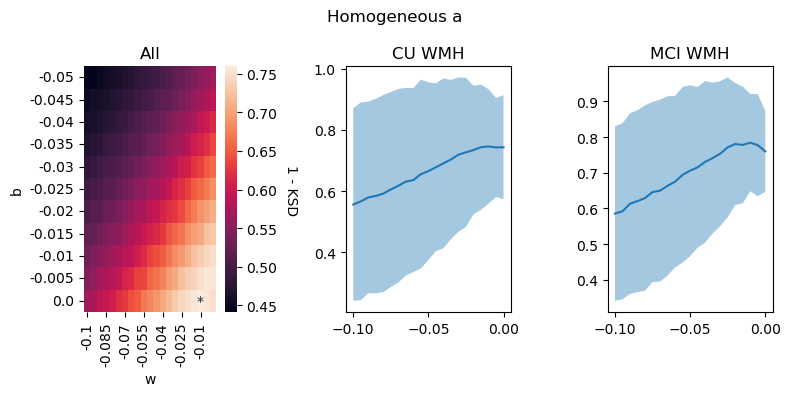

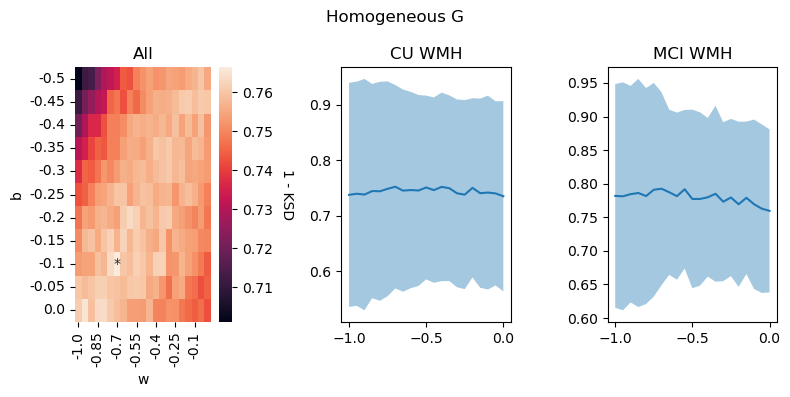

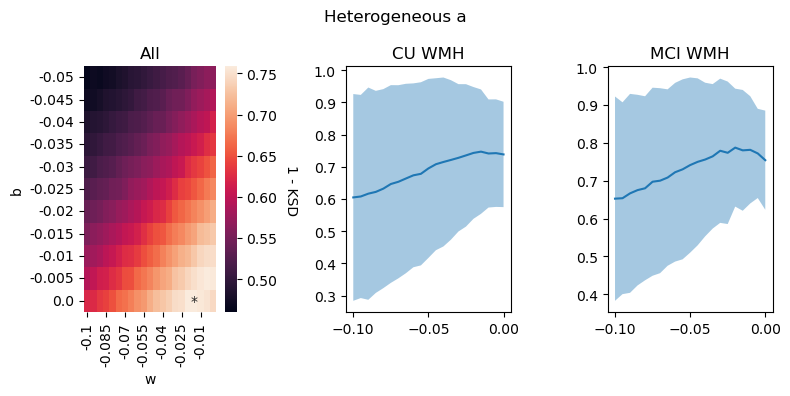

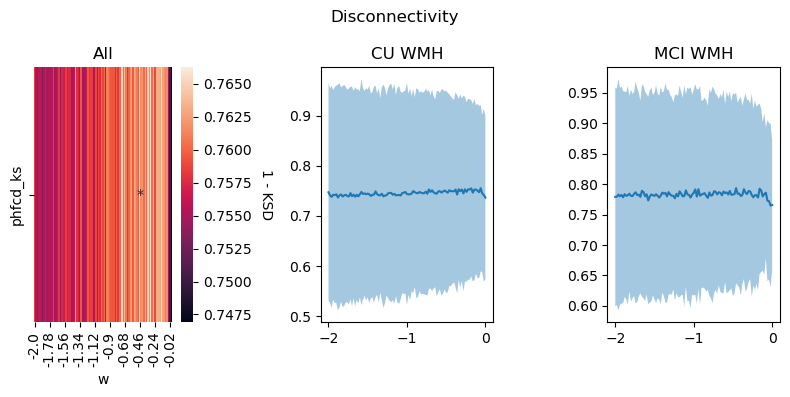

In [366]:
def get_best_b_w_group_and_save_plot(df_big, model):
    dict_title = {
        "homogeneous_a": "Homogeneous a",
        "homogeneous_G": "Homogeneous G",
        "heterogeneous": "Heterogeneous a",
        "disconnectivity": "Disconnectivity",
    }

    best_b_all, best_w_all, table_phfcd_all = find_best_b_w_group("All", model, df_big)
    best_b_cn, best_w_cn, table_phfcd_cn = find_best_b_w_group(
        "CN_WMH", model, df_big, best_b_all
    )
    best_b_mci, best_w_mci, table_phfcd_mci = find_best_b_w_group(
        "MCI_WMH", model, df_big, best_b_all
    )
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    plot_save_heatmaps_group("All", table_phfcd_all, axs[0])
    # plot_save_heatmaps_group("CN_WMH", table_phfcd_cn, axs[1])
    # plot_save_heatmaps_group("MCI_WMH", table_phfcd_mci, axs[2])
    plot_save_best_fit_lineplots_group("CN_WMH", model, df_big, axs[1], best_b_all)
    plot_save_best_fit_lineplots_group("MCI_WMH", model, df_big, axs[2], best_b_all)
    fig.suptitle(dict_title[model])
    fig.tight_layout()
    fig.savefig(FIG_DIR / f"group-all_model-{model}_desc-heatmap-best-average-w-b.png")

    return best_b_all, best_w_all, best_b_cn, best_w_cn, best_b_mci, best_w_mci


(
    best_b_all_a,
    best_w_all_a,
    best_b_cn_a,
    best_w_cn_a,
    best_b_mci_a,
    best_w_mci_a,
) = get_best_b_w_group_and_save_plot(df_a_big, "homogeneous_a")
(
    best_b_all_G,
    best_w_all_G,
    best_b_cn_G,
    best_w_cn_G,
    best_b_mci_G,
    best_w_mci_G,
) = get_best_b_w_group_and_save_plot(df_G_big, "homogeneous_G")
(
    best_b_all_het,
    best_w_all_het,
    best_b_cn_het,
    best_w_cn_het,
    best_b_mci_het,
    best_w_mci_het,
) = get_best_b_w_group_and_save_plot(df_het_big, "heterogeneous")
(
    _,
    best_w_all_disconn,
    _,
    best_w_cn_disconn,
    _,
    best_w_mci_disconn,
) = get_best_b_w_group_and_save_plot(df_disconn_big, "disconnectivity")

In [340]:
def save_dict_best_combinations(best_b_all_a,
                                best_w_all_a,
                                best_w_cn_a,
                                best_w_mci_a,
                                best_b_all_G,
                                best_w_all_G,
                                best_w_cn_G,
                                best_w_mci_G,
                                best_b_all_het,
                                best_w_all_het,
                                best_w_cn_het,
                                best_w_mci_het,
                                best_w_all_disconn,
                                best_w_cn_disconn,
                                best_w_mci_disconn):
    dict_best_combo = {
        "homogeneous_a": [best_b_all_a, best_w_all_a, best_w_cn_a, best_w_mci_a],
        "homogeneous_G": [best_b_all_G, best_w_all_G, best_w_cn_G, best_w_mci_G],
        "heterogeneous": [best_b_all_het, best_w_all_het, best_w_cn_het, best_w_mci_het],
        "disconnectivity": ["", best_w_all_disconn, best_w_cn_disconn, best_w_mci_disconn],
    }
    index_vals = ["best_b_all", "best_w_all", "best_w_cn", "best_w_mci"]
    df_best_combo = pd.DataFrame(dict_best_combo, index=index_vals).T
    df_best_combo.to_csv(
        SIM_DIR / "group-all_data-simulated_model-all_desc-best-b-w-combinations.csv"
    )

In [341]:
def select_b_w_combo(df_boxplot_long, w1, b1, w2, b2, groupname1, groupname2):
    compare_df1 = df_boxplot_long[
        (df_boxplot_long["w"] == w1) & (df_boxplot_long["b"] == b1)
    ]
    compare_df1 = compare_df1[compare_df1["group"] == groupname1]
    compare_df2 = df_boxplot_long[
        (df_boxplot_long["w"] == w2) & (df_boxplot_long["b"] == b2)
    ]
    compare_df2 = compare_df2[compare_df2["group"] == groupname2]
    joined_compare_df = pd.concat([compare_df1, compare_df2])
    return compare_df1, compare_df2, joined_compare_df

In [342]:
def create_df_boxplots(
    group,
    best_b_group_a,
    best_w_group_a,
    best_b_group_G,
    best_w_group_G,
    best_b_group_het,
    best_w_group_het,
    best_w_group_disconn,
):
    # Set the random best to the same value as the non-random best
    best_b_a_rand, best_w_a_rand = best_b_group_a, best_w_group_a
    best_b_G_rand, best_w_G_rand = best_b_group_G, best_w_group_G
    best_b_het_rand, best_w_het_rand = best_b_group_het, best_w_group_het
    best_w_disconn_rand = best_w_group_disconn

    # Create df with only the best values from before for CN
    df_boxplot_compare_base = df_a_big[
        (df_a_big["b"] == 0) & (df_a_big["w"] == 0)
    ].copy()
    df_boxplot_compare_a = df_a_big[
        (df_a_big["b"] == best_b_group_a) & (df_a_big["w"] == best_w_group_a)
    ].copy()
    df_boxplot_compare_a_rand = df_a_rand_big[
        (df_a_rand_big["b"] == best_b_a_rand) & (df_a_rand_big["w"] == best_w_a_rand)
    ].copy()
    df_boxplot_compare_G = df_G_big[
        (df_G_big["b"] == best_b_group_G) & (df_G_big["w"] == best_w_group_G)
    ].copy()
    df_boxplot_compare_G_rand = df_G_rand_big[
        (df_G_rand_big["b"] == best_b_G_rand) & (df_G_rand_big["w"] == best_w_G_rand)
    ].copy()
    df_boxplot_compare_het = df_het_big[
        (df_het_big["b"] == best_b_group_het) & (df_het_big["w"] == best_w_group_het)
    ].copy()
    df_boxplot_compare_het_rand = df_het_rand_big[
        (df_het_rand_big["b"] == best_b_het_rand)
        & (df_het_rand_big["w"] == best_w_het_rand)
    ].copy()
    df_boxplot_compare_disconn = df_disconn_big[
        df_disconn_big["w"] == best_w_group_disconn
    ].copy()
    df_boxplot_compare_disconn_rand = df_disconn_rand_big[
        df_disconn_big["w"] == best_w_disconn_rand
    ].copy()

    df_boxplot_compare_base["model_type"] = "baseline"
    df_boxplot_compare_a_rand["model_type"] = "homogeneous_a"
    df_boxplot_compare_a_rand["random"] = "random"
    df_boxplot_compare_G_rand["model_type"] = "homogeneous_G"
    df_boxplot_compare_G_rand["random"] = "random"
    df_boxplot_compare_het_rand["model_type"] = "heterogeneous"
    df_boxplot_compare_het_rand["random"] = "random"
    df_boxplot_compare_disconn_rand["model_type"] = "disconnectivity"
    df_boxplot_compare_disconn_rand["random"] = "random"

    df_boxplot_compare = pd.concat(
        [
            df_boxplot_compare_base,
            df_boxplot_compare_a,
            df_boxplot_compare_G,
            df_boxplot_compare_het,
            df_boxplot_compare_disconn,
        ]
    )

    # Create a unified long df to compare the model performance between random vs. non-random
    df_boxplot_compare_rand = pd.concat(
        [
            df_boxplot_compare_a,
            df_boxplot_compare_a_rand,
            df_boxplot_compare_G,
            df_boxplot_compare_G_rand,
            df_boxplot_compare_het,
            df_boxplot_compare_het_rand,
            df_boxplot_compare_disconn,
            df_boxplot_compare_disconn_rand,
        ]
    )
    if group != "All":
        df_boxplot_compare_group = df_boxplot_compare[
            df_boxplot_compare["Group_bin_Fazekas"] == group
        ]
        df_boxplot_compare_group_rand = df_boxplot_compare_rand[
            df_boxplot_compare_rand["Group_bin_Fazekas"] == group
        ]
    else:
        df_boxplot_compare_group = df_boxplot_compare
        df_boxplot_compare_group_rand = df_boxplot_compare_rand
    return df_boxplot_compare_group, df_boxplot_compare_group_rand


save_dict_best_combinations(best_b_all_a,
                            best_w_all_a,
                            best_w_cn_a,
                            best_w_mci_a,
                            best_b_all_G,
                            best_w_all_G,
                            best_w_cn_G,
                            best_w_mci_G,
                            best_b_all_het,
                            best_w_all_het,
                            best_w_cn_het,
                            best_w_mci_het,
                            best_w_all_disconn,
                            best_w_cn_disconn,
                            best_w_mci_disconn)

df_boxplot_compare_all, df_boxplot_compare_rand_all = create_df_boxplots(
    "All",
    best_b_all_a,
    best_w_all_a,
    best_b_all_G,
    best_w_all_G,
    best_b_all_het,
    best_w_all_het,
    best_w_all_disconn,
)
df_boxplot_compare_cn, df_boxplot_compare_rand_cn = create_df_boxplots(
    "CN_WMH",
    best_b_all_a,
    best_w_cn_a,
    best_b_all_G,
    best_w_cn_G,
    best_b_all_het,
    best_w_cn_het,
    best_w_cn_disconn,
)
df_boxplot_compare_mci, df_boxplot_compare_rand_mci = create_df_boxplots(
    "MCI_WMH",
    best_b_all_a,
    best_w_mci_a,
    best_b_all_G,
    best_w_mci_G,
    best_b_all_het,
    best_w_mci_het,
    best_w_mci_disconn,
)

In [343]:
print("The best (b, w) for all subjects are as follows:")
print(f"Homogeneous a-weighted model: {best_b_all_a, best_w_all_a}")
print(f"Homogeneous G-weighted model: {best_b_all_G, best_w_all_G}")
print(f"Heterogeneous a-weighted model: {best_b_all_het, best_w_all_het}")
print("The best w for all subjects for the disconnectivity is as follows:")
print(f"{best_w_all_disconn}")
print("The best (b, w) for CN subjects are as follows:")
print(f"Homogeneous a-weighted model: {best_b_cn_a, best_w_cn_a}")
print(f"Homogeneous G-weighted model: {best_b_cn_G, best_w_cn_G}")
print(f"Heterogeneous a-weighted model: {best_b_cn_het, best_w_cn_het}")
print("The best w for CN subjects for the disconnectivity is as follows:")
print(f"{best_w_cn_disconn}")
print("######################################################################")
print("The best b and w for MCI subjects are as follows:")
print(f"Homogeneous a-weighted model: {best_b_mci_a, best_w_mci_a}")
print(f"Homogeneous G-weighted model: {best_b_mci_G, best_w_mci_G}")
print(f"Heterogeneous a-weighted model: {best_b_mci_het, best_w_mci_het}")
print("The best w for MCI subjects for the disconnectivity is as follows:")
print(f"{best_w_mci_disconn}")

dict_summary_best_w_b = {
    "": ["b", "w", "b", "w", "b", "w"],
    "Homogeneous a": [
        f"{best_b_all_a}",
        f"{best_b_all_a}",
        f"{best_b_cn_a}",
        f"{best_w_cn_a}",
        f"{best_b_mci_a}",
        f"{best_w_mci_a}",
    ],
    "Homogeneous G": [
        f"{best_b_all_G}",
        f"{best_w_all_G}",
        f"{best_b_cn_G}",
        f"{best_w_cn_G}",
        f"{best_b_mci_G}",
        f"{best_w_mci_G}",
    ],
    "Heterogeneous a": [
        f"{best_b_all_het}",
        f"{best_w_all_het}",
        f"{best_b_cn_het}",
        f"{best_w_cn_het}",
        f"{best_b_mci_het}",
        f"{best_w_mci_het}",
    ],
    "Disconnectivity": [
        "",
        f"{best_w_all_disconn}",
        "",
        f"{best_w_cn_disconn}",
        "",
        f"{best_w_mci_disconn}",
    ],
}
df_summary_best_w_b = pd.DataFrame.from_dict(dict_summary_best_w_b).T
df_summary_best_w_b.columns = ["All_b", "All_w", "CU_WMH_b", "CU_WMH_w", "MCI_WMH_b", "MCI_WMH_w"]
df_summary_best_w_b.to_csv(TBL_DIR / "group-all_data-simulated_model-all_desc-best-avg-group-fits.csv")
df_summary_best_w_b.to_latex(TBL_DIR / "group-all_data-simulated_model-all_desc-best-avg-group-fits.tex")

The best (b, w) for all subjects are as follows:
Homogeneous a-weighted model: (0.0, -0.01)
Homogeneous G-weighted model: (-0.1, -0.7)
Heterogeneous a-weighted model: (0.0, -0.015)
The best w for all subjects for the disconnectivity is as follows:
-0.46
The best (b, w) for CN subjects are as follows:
Homogeneous a-weighted model: (0.0, -0.01)
Homogeneous G-weighted model: (-0.1, -0.7)
Heterogeneous a-weighted model: (0.0, -0.015)
The best w for CN subjects for the disconnectivity is as follows:
-0.06
######################################################################
The best b and w for MCI subjects are as follows:
Homogeneous a-weighted model: (0.0, -0.01)
Homogeneous G-weighted model: (-0.1, -0.7)
Heterogeneous a-weighted model: (0.0, -0.02)
The best w for MCI subjects for the disconnectivity is as follows:
-0.46


/tmp/ipykernel_2839816/51498260.py:59: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_summary_best_w_b.to_latex(TBL_DIR / "group-all_data-simulated_model-all_desc-best-avg-group-fits.tex")


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

homogeneous_G_random vs. homogeneous_G_not_random: Wilcoxon test (paired samples), P_val:4.147e-02 Stat=1.468e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

disconnectivity_random vs. disconnectivity_not_random: Wilcoxon test (paired samples), P_val:2.099e-02 Stat=5.360e+02


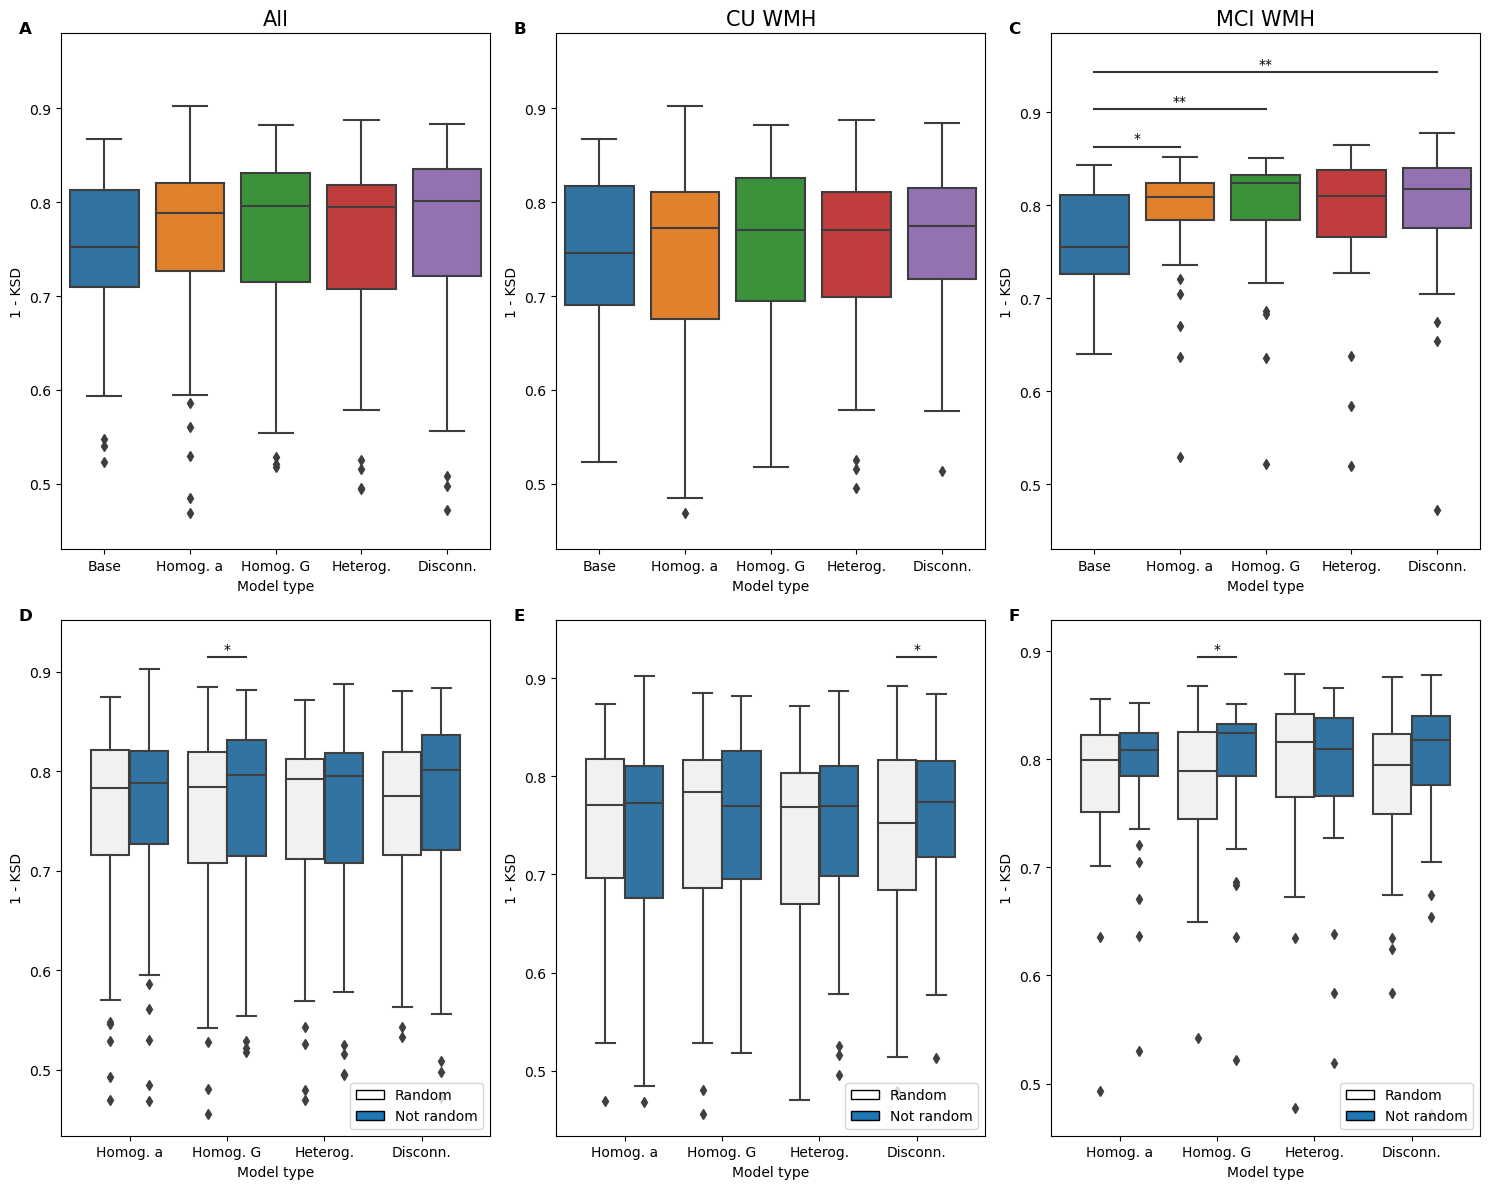

In [344]:
def plot_best_avg_phfcd(group, df, df_compare_with_rand, axs):
    dict_group_groupnames = {
        "all": "All",
        "CN_WMH": "CU WMH",
        "MCI_WMH": "MCI WMH",
    }
    plot_obs(df, group, "avg", "phfcd_ks", axs[0])
    plot_random_comparison(df_compare_with_rand, "phfcd_ks", axs[1])
    axs[0].set_xlabel("Model type")
    axs[0].set_ylabel("1 - KSD")
    axs[0].set_title(dict_group_groupnames[group], fontsize = 15)

# Plot the boxplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))
axs_col_one = axs[:, 0]
axs_col_two = axs[:, 1]
axs_col_three = axs[:, 2]
plot_best_avg_phfcd(
    "all", df_boxplot_compare_all, df_boxplot_compare_rand_all, axs_col_one
)
plot_best_avg_phfcd(
    "CN_WMH", df_boxplot_compare_cn, df_boxplot_compare_rand_cn, axs_col_two
)
plot_best_avg_phfcd(
    "MCI_WMH", df_boxplot_compare_mci, df_boxplot_compare_rand_mci, axs_col_three
)
write_figure_letters(axs)
fig.tight_layout()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

homogeneous_a_CN_WMH vs. homogeneous_a_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:3.452e-02 U_stat=6.410e+02
homogeneous_G_CN_WMH vs. homogeneous_G_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:3.682e-02 U_stat=6.440e+02
disconnectivity_CN_WMH vs. disconnectivity_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:4.009e-02 U_stat=6.480e+02


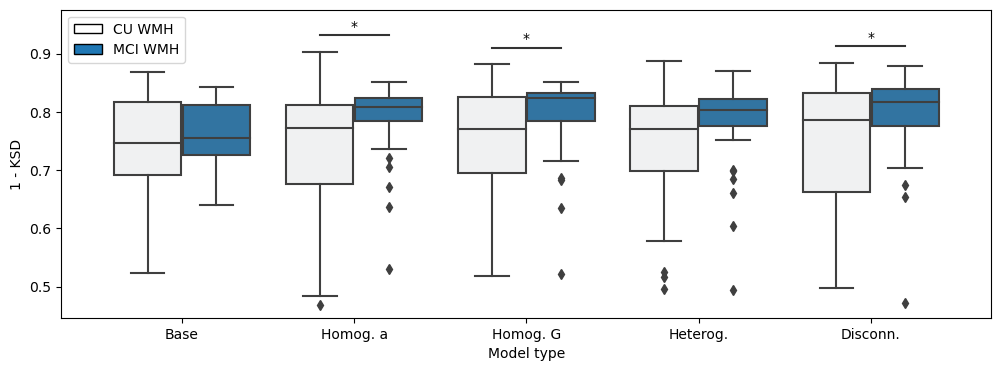

In [345]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
plot_cn_mci_comparison("phfcd_ks", df_boxplot_compare_all, ax)

In [346]:
def make_table_fitting_results(groupname, df_boxplot_compare_group, modality):
    df = pd.read_csv(
        SIM_DIR
        / f"group-{groupname}_data-simulated-{modality}_model-all_desc-df-fitting-comparison.csv",
        index_col=0,
    )
    test_name = df.columns[0]
    index_values = [
        "baseline",
        "homogeneous_a",
        "homogeneous_G",
        "heterogeneous",
        "disconnectivity",
    ]
    dict_comparison = {
        "homogeneous_a": "baseline_homogeneous_a",
        "homogeneous_G": "baseline_homogeneous_G",
        "heterogeneous": "baseline_heterogeneous",
        "disconnectivity": "baseline_disconnectivity",
    }
    df_comparisons = (
        df_boxplot_compare_group[["phfcd_ks", "model_type"]]
        .groupby("model_type")
        .describe()
        .iloc[:, -4:-1]
    )
    df_comparisons = df_comparisons.reset_index().droplevel(0, axis=1)
    df_comparisons.index = df_comparisons.iloc[:, 0]
    df_comparisons = df_comparisons.loc[index_values]
    df_comparisons = df_comparisons.iloc[:, 1:]
    list_pval = [np.nan]
    # df_comparisons = df_comparisons.loc[index_values]
    for k, v in dict_comparison.items():
        pval = df.loc[v, test_name]
        list_pval.append(pval.split("Stat")[0].strip().split(":")[1])
    df_comparisons["pval (BH significance)"] = list_pval
    return df_comparisons

In [347]:
# import pandas as pd
# from scipy.stats import f_oneway
# from statsmodels.stats.multicomp import pairwise_tukeyhsd

# # Assuming your DataFrame is named df
# # and the column with model types is named 'model_type'
# # and the column with phfcd_ks scores is named 'phfcd_ks'

# df = df_boxplot_compare_mci.copy()
# # Extract data for each model
# baseline_data = df[df["model_type"] == "baseline"]["phfcd_ks"]
# homogeneous_a_data = df[df["model_type"] == "homogeneous_a"]["phfcd_ks"]
# homogeneous_G_data = df[df["model_type"] == "homogeneous_G"]["phfcd_ks"]
# heterogeneous_data = df[df["model_type"] == "heterogeneous"]["phfcd_ks"]
# disconnectivity_data = df[df["model_type"] == "disconnectivity"]["phfcd_ks"]

# # Perform ANOVA
# f_statistic, p_value = f_oneway(
#     baseline_data,
#     homogeneous_a_data,
#     homogeneous_G_data,
#     heterogeneous_data,
#     disconnectivity_data,
# )

# print(f"ANOVA F-statistic: {f_statistic}")
# print(f"ANOVA p-value: {p_value}")

# # Check if ANOVA is statistically significant
# if p_value < 0.05:
#     # Perform post-hoc Tukey's HSD test
#     posthoc = pairwise_tukeyhsd(df["phfcd_ks"], df["model_type"], alpha=0.05)

#     # Display the results of the post-hoc test
#     print(posthoc)
# else:
#     print("No significant difference among the groups.")

In [348]:
test_type = "Wilcoxon test (paired samples)"
tbl_avg_all = make_table_fitting_results("all", df_boxplot_compare_all, "avg")
tbl_avg_cn = make_table_fitting_results("CN_WMH", df_boxplot_compare_cn, "avg")
tbl_avg_mci = make_table_fitting_results("MCI_WMH", df_boxplot_compare_mci, "avg")
print("Table avg all:")
print(tbl_avg_all)
print("Table avg CU WMH:")
print(tbl_avg_cn)
print("Table avg MCI WMH:")
print(tbl_avg_mci)

Table avg all:
                      25%       50%       75% pval (BH significance)
                                                                    
baseline         0.709400  0.752247  0.813383                    NaN
homogeneous_a    0.726582  0.788060  0.820374              2.276e-01
homogeneous_G    0.714767  0.795926  0.830946         3.943e-02 (ns)
heterogeneous    0.707590  0.794946  0.818448              1.985e-01
disconnectivity  0.720928  0.801138  0.835803              5.002e-02
Table avg CU WMH:
                      25%       50%       75% pval (BH significance)
                                                                    
baseline         0.690933  0.746316  0.817070                    NaN
homogeneous_a    0.675671  0.773034  0.810997              9.146e-01
homogeneous_G    0.694980  0.769928  0.825979              5.381e-01
heterogeneous    0.698607  0.769887  0.810488              7.901e-01
disconnectivity  0.718055  0.774209  0.815393              9.761e-02
T

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Group-average vs. Subj-specific G: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:2.627e-03 Stat=1.235e+03
Subj-specific G vs. Subj-specific Disconn.: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:8.613e-01 Stat=1.916e+03
Group-average vs. Subj-specific Disconn.: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:8.866e-03 Stat=1.329e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Group-average vs. Subj-specific G: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:2.627e-03 Stat=1.235e+03
Subj-specific G vs. Subj-specific Disconn.: Wilcoxon test (paired sa

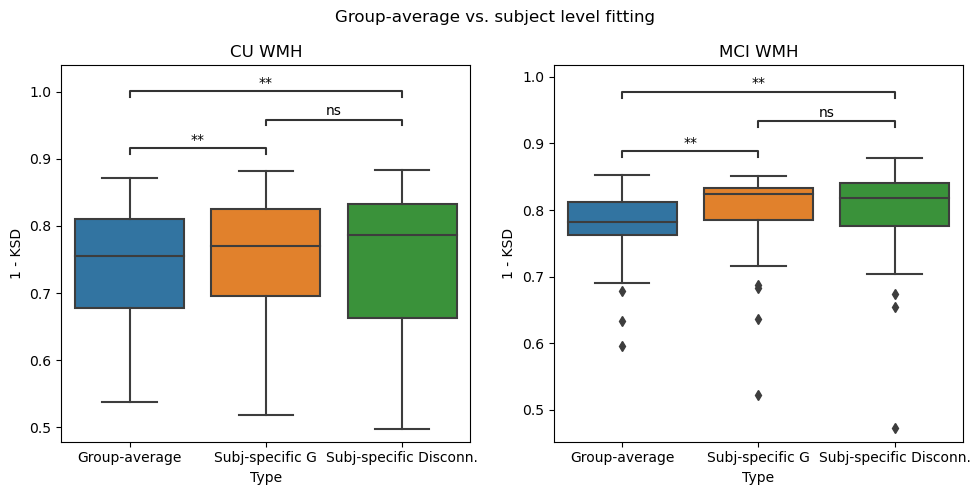

In [349]:
def plot_group_subj_comparison(df_compare, group, ax):
    order = ["Group-average", "Subj-specific G", "Subj-specific Disconn."]
    pairs = [("Group-average", "Subj-specific G"),
            ("Group-average", "Subj-specific Disconn."),
            ("Subj-specific G", "Subj-specific Disconn."),]
    dict_title = {"CN_WMH": "CU WMH",
                  "MCI_WMH": "MCI WMH",}
    f = sns.boxplot(data = df_compare[df_compare["Group_bin_Fazekas"] == group], x = "type", y = "phfcd_ks", ax = ax, order = order)
    annotator = Annotator(f, pairs, data=df_compare, x="type", y="phfcd_ks", order=order)
    annotator.configure(
        test="Wilcoxon",
        text_format="star",
        loc="inside",
        verbose=1,
        hide_non_significant=False,
        comparisons_correction = "BH"
    )
    _, results = annotator.apply_and_annotate()
    ax.set_ylabel("1 - KSD")
    ax.set_xlabel("Type")
    ax.set_title(dict_title[group])


# Here we plot the results of the group average simulation vs the subject specific simulations
df_best_val_cn_wmh = pd.read_csv(SIM_GROUP_DIR / "CN_WMH" / "group-CN_WMH_data-empirical_model-all_desc-df-best-values-and-indices.csv", index_col = 0)
df_best_val_mci_wmh = pd.read_csv(SIM_GROUP_DIR / "MCI_WMH" / "group-MCI_WMH_data-empirical_model-all_desc-df-best-values-and-indices.csv", index_col = 0)

# Here we just assume that G is the same for all subjects in a particular group and don't wait it for WMH (log)
best_group_w_cn_wmh = best_group_w_mci_wmh = 0.0
# The b we used lead to slightly different values of G, so we choose the one that is more similar to the best G for the group
# e.g., best_group = best_G + 0*WMH - b
best_group_b_cn_wmh_filter = np.isclose(df_best_val_cn_wmh["CN_WMH"]["best_G_model-homogeneous_G"] - best_G, bs_G, atol=0.01)
best_group_b_cn_wmh = round(bs_G[best_group_b_cn_wmh_filter][0], 2)
best_group_b_mci_wmh_filter = np.isclose(df_best_val_mci_wmh["MCI_WMH"]["best_G_model-homogeneous_G"] - best_G, bs_G, atol=0.01)
best_group_b_mci_wmh = bs_G[best_group_b_mci_wmh_filter][0]
# We create the dataframe with the results of the best G obtained from the group-averaged models
df_compare_best_group_cn = df_G_big[(df_G_big["Group_bin_Fazekas"] == "CN_WMH") &(df_G_big["b"] == best_group_b_cn_wmh) & (df_G_big["w"] == best_group_w_cn_wmh)].copy()
df_compare_best_group_mci = df_G_big[(df_G_big["Group_bin_Fazekas"] == "MCI_WMH") &(df_G_big["b"] == best_group_b_mci_wmh) & (df_G_big["w"] == best_group_w_mci_wmh)].copy()
df_compare_best_group = pd.concat([df_compare_best_group_cn, df_compare_best_group_mci], axis = 0)
df_compare_best_group["type"] = "Group-average"

# We get the results of our subject-level models for the homogeneous_G and disconnectivity
df_compare_best_subj_G = df_boxplot_compare_all.loc[df_boxplot_compare_all["model_type"] == "homogeneous_G"].copy()
df_compare_best_subj_G["type"] = "Subj-specific G"
df_compare_best_subj_disconn = df_boxplot_compare_all.loc[df_boxplot_compare_all["model_type"] == "disconnectivity"].copy()
df_compare_best_subj_disconn["type"] = "Subj-specific Disconn."
df_compare_best_subj = pd.concat([df_compare_best_subj_G, df_compare_best_subj_disconn], axis = 0)
df_compare_best_group_vs_subj = pd.concat([df_compare_best_group, df_compare_best_subj], axis = 0)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
plot_group_subj_comparison(df_compare_best_group_vs_subj, "CN_WMH", axs[0])
plot_group_subj_comparison(df_compare_best_group_vs_subj, "MCI_WMH", axs[1])
fig.suptitle("Group-average vs. subject level fitting")
fig.tight_layout()

In [350]:
df_boxplot_compare_G = df_boxplot_compare_all[df_boxplot_compare_all["model_type"] == "homogeneous_G"].copy()
df_boxplot_compare_G["G"] = 1.98 + df_boxplot_compare_G["w"].astype(float) * df_boxplot_compare_G["wmh_load"].astype(float) + df_boxplot_compare_G["b"].astype(float)
df_petTOAD_G = pd.merge(df_boxplot_compare_G[["PTID", "G"]], df_petTOAD, on = "PTID")

In [351]:
def lin_reg_parm(df, group, x, y):

    X = pd.to_numeric(df[x])
    Y = pd.to_numeric(df[y])
    # Use statsmodels to calculate p-values for the coefficients
    X_with_intercept = sm.add_constant(
        X
    )  # Add a constant (intercept) term to the features
    model = sm.OLS(
        Y, X_with_intercept
    ).fit()  # Fit an OLS (ordinary least squares) model
    # Get the coefficients (w) and intercept (b)
    lr_slope = model.params[x]
    lr_int = model.params["const"]
    r2 = model.rsquared
    p_slope = model.pvalues[x]

    return group, lr_slope, lr_int, r2, p_slope

def regplot_with_lr(group, df, x, y, ax, color=None, max_phfcd=False):
    scatter_size = 20
 
    if group != "All":
        df = df[df["Group_bin_Fazekas"] == group]
    _, lr_slope, lr_int, r2, p_slope = lin_reg_parm(df, group, x, y)
    if x == "wmh_load":
        x_name = "WMH (log)"
    else:
        x_name = x

    if max_phfcd:
        dict_group = {"All": "All",
                      "CN_WMH": "CU WMH max. fit",
                      "MCI_WMH": "MCI WMH max. fit"}
    else:
        dict_group = {"All": "All",
                      "CN_WMH": "CU WMH",
                      "MCI_WMH": "MCI WMH"}

    if p_slope >= 0.05:
        if group == "All":
            sns.scatterplot(data=df, x=x, y=y, ax=ax, color = color, label = dict_group[group])
        else:
            sns.scatterplot(
                data=df[df["Group_bin_Fazekas"] == group],
                x=x,
                y=y,
                ax=ax,
                color=color,
                label = dict_group[group],
            )
    else:
        if group == "All":
            sns.regplot(data=df, x=x, y=y, ax=ax, color = color, label = dict_group[group], scatter_kws={'s': scatter_size})
        else:
            sns.regplot(
                data=df[df["Group_bin_Fazekas"] == group],
                x=x,
                y=y,
                ax=ax,
                color=color,
                scatter_kws={'s': scatter_size},
                label = dict_group[group]
            )
        ax.legend()
    if p_slope < 0.0001:
        p_slope = "< 0.001"
    else:
        p_slope = f"= {p_slope:.3f}"

    ax.set_ylabel(f"{y}")
    ax.set_xlabel(f"{x_name}")
    ax.set_title(f"{y} = {lr_slope:.2f} * {x} + {lr_int:.2f}, p {p_slope}", fontsize = 10)

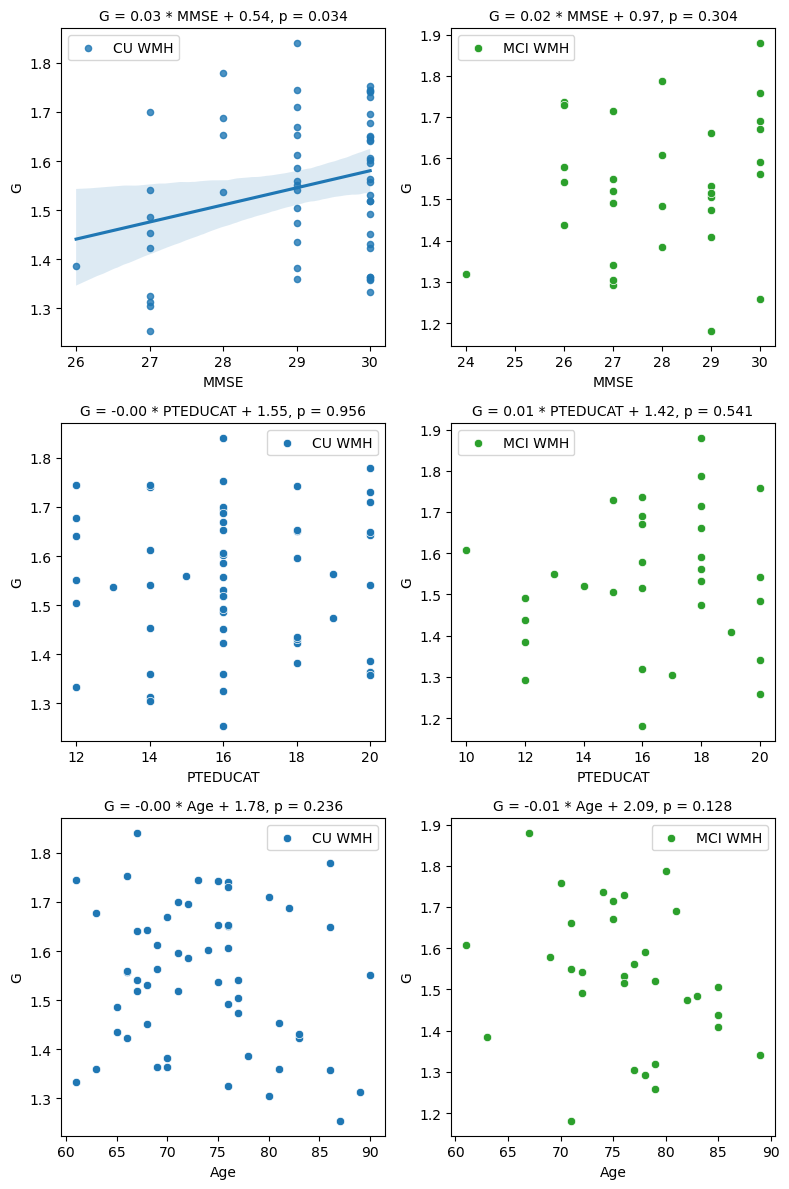

In [352]:
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (8, 12))
regplot_with_lr("CN_WMH", df_petTOAD_G, y = "G", x = "MMSE", ax = axs[0, 0], color = "tab:blue")
regplot_with_lr("CN_WMH", df_petTOAD_G, y = "G", x = "PTEDUCAT", ax = axs[1, 0], color = "tab:blue")
regplot_with_lr("CN_WMH", df_petTOAD_G, y = "G", x = "Age", ax = axs[2, 0], color = "tab:blue")
regplot_with_lr("MCI_WMH", df_petTOAD_G, y = "G", x = "MMSE", ax = axs[0, 1], color = "tab:green")
regplot_with_lr("MCI_WMH", df_petTOAD_G, y = "G", x = "PTEDUCAT", ax = axs[1, 1], color = "tab:green")
regplot_with_lr("MCI_WMH", df_petTOAD_G, y = "G", x = "Age", ax = axs[2, 1], color = "tab:green")
fig.tight_layout()

# MAX analyses

In [353]:
def create_max_df(df_big, model, best_b_all_model=None):
    if model != "disconnectivity":
        # filter for the best b obtained in the whole group
        df_max_phfcd_pre = df_big[df_big["b"] == best_b_all_model]
    else:
        df_max_phfcd_pre = df_big
    idx = df_max_phfcd_pre.groupby("PTID")["phfcd_ks"].idxmax()
    df_max_phfcd = df_max_phfcd_pre.loc[idx]
    return df_max_phfcd

In [354]:
df_max_phfcd_a = create_max_df(df_a_big, "homogeneous_a", best_b_all_a)
df_max_phfcd_G = create_max_df(df_G_big, "homogeneous_G", best_b_all_G)
df_max_phfcd_het = create_max_df(df_het_big, "heterogeneous", best_b_all_het)
df_max_phfcd_disconn = create_max_df(df_disconn_big, "disconnectivity")

# Add the calculated value of a and G for the homogeneous models.
df_max_phfcd_a["a"] = (
    a + df_max_phfcd_a["w"] * df_max_phfcd_a["wmh_load"] + df_max_phfcd_a["b"]
)
df_max_phfcd_G["G"] = (
    best_G + df_max_phfcd_G["w"] * df_max_phfcd_G["wmh_load"] + df_max_phfcd_G["b"]
)

In [355]:
# Non random max dataframes
df_max_phfcd_merged = pd.concat(
    [df_base, df_max_phfcd_a, df_max_phfcd_G, df_max_phfcd_het, df_max_phfcd_disconn],
    axis=0,
).reset_index(
    drop=True
)  # add df_max_phfcd_het, df_max_phfcd_disconn
df_max_phfcd_cn = df_max_phfcd_merged[
    df_max_phfcd_merged["Group_bin_Fazekas"] == "CN_WMH"
].reset_index(drop=True)
df_max_phfcd_mci = df_max_phfcd_merged[
    df_max_phfcd_merged["Group_bin_Fazekas"] == "MCI_WMH"
].reset_index(drop=True)
# Random max dataframes
list_tuples_df = [
    (df_max_phfcd_a, df_a_rand_big, "homogeneous_a"),
    (df_max_phfcd_G, df_G_rand_big, "homogeneous_G"),
    (df_max_phfcd_het, df_het_rand_big, "heterogeneous"),
    (df_max_phfcd_disconn, df_disconn_rand_big, "disconnectivity"),
]
df_max_phfcd_merged_rand = create_merged_df_rand(list_tuples_df)
df_max_phfcd_merged_rand = df_max_phfcd_merged_rand[
    df_max_phfcd_merged_rand["model_type"] != "baseline"
].reset_index(drop=True)
df_max_phfcd_cn_rand = df_max_phfcd_merged_rand[
    df_max_phfcd_merged_rand["Group_bin_Fazekas"] == "CN_WMH"
].reset_index(drop=True)
df_max_phfcd_mci_rand = df_max_phfcd_merged_rand[
    df_max_phfcd_merged_rand["Group_bin_Fazekas"] == "MCI_WMH"
].reset_index(drop=True)

# Compare random-non-random dataframes
df_max_phfcd_compare_with_rand = pd.concat(
    [df_max_phfcd_merged, df_max_phfcd_merged_rand]
).reset_index(drop=True)
df_max_phfcd_cn_compare_with_rand = pd.concat(
    [df_max_phfcd_cn, df_max_phfcd_cn_rand]
).reset_index(drop=True)
df_max_phfcd_mci_compare_with_rand = pd.concat(
    [df_max_phfcd_mci, df_max_phfcd_mci_rand]
).reset_index(drop=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

baseline vs. homogeneous_a: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:1.291e-07 Stat=6.890e+02
baseline vs. homogeneous_G: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:2.190e-06 Stat=8.200e+02
baseline vs. heterogeneous: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:4.358e-08 Stat=6.420e+02
baseline vs. disconnectivity: Wilcoxon test (paired samples) with Benjamini-Hochberg correction, P_val:3.058e-08 Stat=6.270e+02


ValueError: The samples x and y must have the same length.

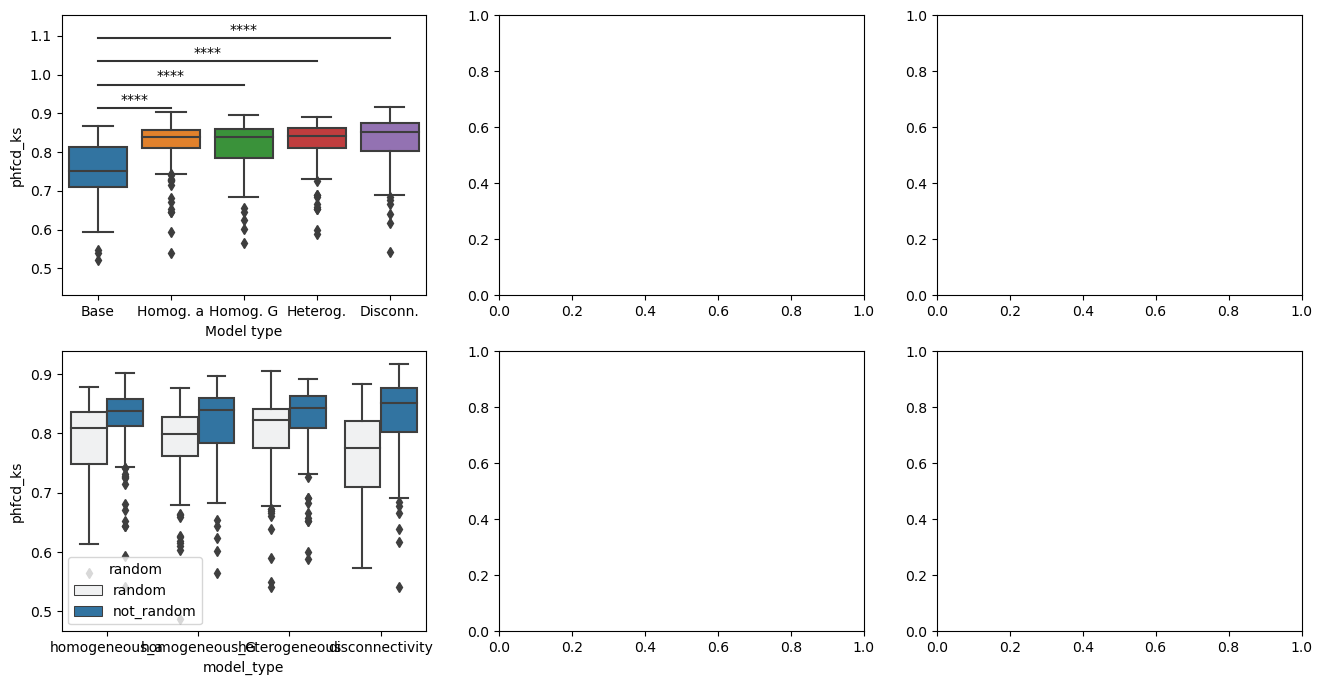

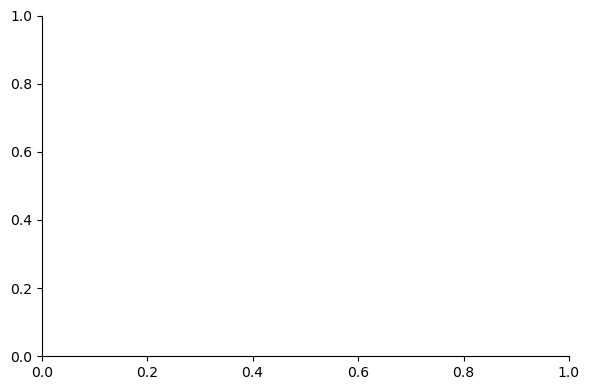

In [356]:
def plot_max_phfcd(group, df, df_compare_with_rand, axs):
    dict_groupname_group = {"all": "All", "CN_WMH": "CU WMH", "MCI_WMH": "MCI WMH"}
    plot_obs(df, group, "max", "phfcd_ks", axs[0])
    plot_random_comparison(df_compare_with_rand, "phfcd_ks", axs[1])
    axs[0].set_xlabel("Model type")
    axs[0].set_ylabel("1 - KSD")
    axs[0].set_title(dict_groupname_group[group])


# Plot the boxplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
axs_col_one = axs[:, 0]
axs_col_two = axs[:, 1]
axs_col_three = axs[:, 2]
plot_max_phfcd("all", df_max_phfcd_merged, df_max_phfcd_compare_with_rand, axs_col_one)
plot_max_phfcd(
    "CN_WMH", df_max_phfcd_cn, df_max_phfcd_cn_compare_with_rand, axs_col_two
)
plot_max_phfcd(
    "MCI_WMH", df_max_phfcd_mci, df_max_phfcd_mci_compare_with_rand, axs_col_three
)
write_figure_letters(axs)
fig.tight_layout()

In [ ]:
test_type = "Wilcoxon test (paired samples)"
tbl_max_all = make_table_fitting_results("all", df_max_phfcd_merged, "max")
tbl_max_cn = make_table_fitting_results("CN_WMH", df_max_phfcd_cn, "max")
tbl_max_mci = make_table_fitting_results("MCI_WMH", df_max_phfcd_mci, "max")
print("All subjs:")
print(tbl_max_all)
print("CU WMH:")
print(tbl_max_cn)
print("MCI WMH:")
print(tbl_max_mci)

All subjs:
                      25%       50%       75% pval (BH significance)
                                                                    
baseline         0.709400  0.752247  0.813383                    NaN
homogeneous_a    0.811824  0.837924  0.857442              1.291e-07
homogeneous_G    0.784430  0.839338  0.859364              2.190e-06
heterogeneous    0.809854  0.842643  0.863018              4.358e-08
disconnectivity  0.801796  0.851723  0.876470              3.058e-08
CU WMH:
                      25%       50%       75% pval (BH significance)
                                                                    
baseline         0.690933  0.746316  0.817070                    NaN
homogeneous_a    0.787740  0.835828  0.863073              9.420e-05
homogeneous_G    0.768374  0.824373  0.857447              1.078e-03
heterogeneous    0.783055  0.832859  0.864420              9.734e-05
disconnectivity  0.771111  0.846722  0.876699              1.740e-04
MCI WMH:
      

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

homogeneous_a_CN_WMH vs. homogeneous_a_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:8.339e-01 U_stat=8.590e+02
baseline_CN_WMH vs. baseline_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:5.881e-01 U_stat=8.210e+02
homogeneous_G_CN_WMH vs. homogeneous_G_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:7.475e-02 U_stat=6.790e+02
heterogeneous_CN_WMH vs. heterogeneous_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:1.991e-01 U_stat=7.360e+02
disconnectivity_CN_WMH vs. disconnectivity_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:1.814e-01 U_stat=7.300e+02


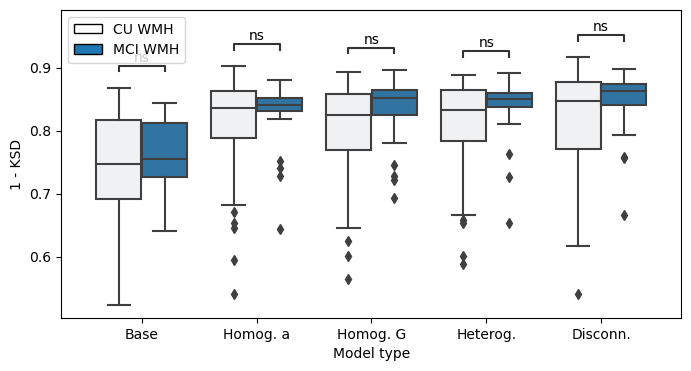

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
plot_cn_mci_comparison("phfcd_ks", df_max_phfcd_merged, ax)

In [ ]:
def all_lin_reg_wmh_parm(model_type):
    parm = model_type[-1:]
    list_res_w = []
    list_res_parm = []
    list_df = [df_max_phfcd_merged, df_max_phfcd_cn, df_max_phfcd_mci]
    list_names = ["All", "CU WMH", "MCI WMH"]
    list_col_names = ["Group", "Slope", "Intercept", "R^2", "p-value"]
    for i, df in enumerate(list_df):
        list_res_w.append(
            lin_reg_parm(
                df[df["model_type"] == model_type], list_names[i], "wmh_load", "w"
            )
        )
        list_res_parm.append(
            lin_reg_parm(
                df[df["model_type"] == model_type], list_names[i], "wmh_load", parm
            )
        )

    df_res_w = pd.DataFrame(list_res_w, columns=list_col_names)
    df_res_parm = pd.DataFrame(list_res_parm, columns=list_col_names)
    df_res_w["Model"] = model_type
    df_res_parm["Model"] = model_type
    df_res_w["Parameter"] = "w_" + parm
    df_res_parm["Parameter"] = parm
    df_res = pd.concat([df_res_w, df_res_parm])
    df_res = df_res.round(3).astype(str)
    df_res["p-value"] = np.where(df_res["p-value"] == "0.0", "< 0.001", df_res["p-value"])
    df_res.index = df_res["Group"]
    df_res = df_res.drop(columns="Group")
    return df_res

# fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
# regplot_with_lr("All", df_max_phfcd_a, "wmh_load", "w", axs[0, 0], color ="tab:orange")
# regplot_with_lr("All", df_max_phfcd_a, "wmh_load", "a", axs[1, 0], color ="tab:orange")
# regplot_with_lr("CN_WMH", df_max_phfcd_a, "wmh_load", "w", axs[0, 1], color ="tab:blue")
# regplot_with_lr("CN_WMH", df_max_phfcd_a, "wmh_load", "a", axs[1, 1], color ="tab:blue")
# regplot_with_lr("MCI_WMH", df_max_phfcd_a, "wmh_load", "w", axs[0, 2], color ="tab:green")
# regplot_with_lr("MCI_WMH", df_max_phfcd_a, "wmh_load", "a", axs[1, 2], color ="tab:green")
# fig.tight_layout()

# table_a = all_lin_reg_wmh_parm("homogeneous_a")
# table_a

,Slope,Intercept,R^2,p-value,Model,Parameter
Group,,,,,,
All,-0.169,-0.477,0.012,0.315,homogeneous_G,w_G
CU WMH,-0.193,-0.425,0.013,0.399,homogeneous_G,w_G
MCI WMH,-0.109,-0.581,0.007,0.655,homogeneous_G,w_G
All,-0.645,1.914,0.358,< 0.001,homogeneous_G,G
CU WMH,-0.621,1.921,0.311,< 0.001,homogeneous_G,G
MCI WMH,-0.666,1.889,0.436,< 0.001,homogeneous_G,G


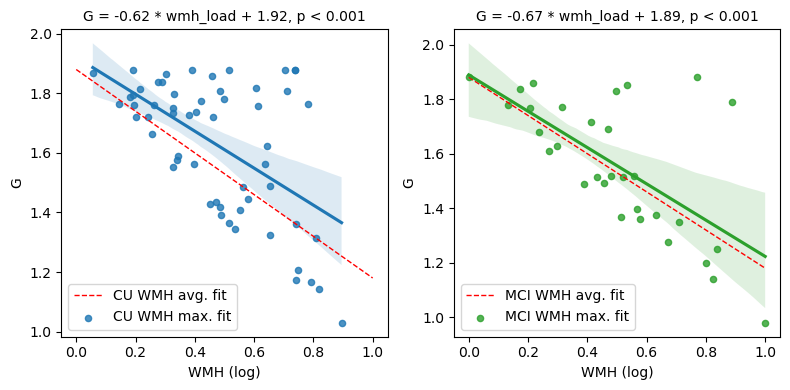

In [ ]:
def plot_line_group(group, ax, best_w, best_b):
    x_values = np.linspace(0, 1, 100)
    y_values = best_G + best_w * x_values + best_b
    ax.plot(x_values, y_values, "r--", linewidth = 1, label = f"{group} avg. fit")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
plot_line_group("CU WMH", axs[0], best_w_cn_G, best_b_all_G)
plot_line_group("MCI WMH", axs[1], best_w_mci_G, best_b_all_G)
regplot_with_lr("CN_WMH", df_max_phfcd_G, "wmh_load", "G", axs[0], color ="tab:blue", max_phfcd=True)
regplot_with_lr("MCI_WMH", df_max_phfcd_G, "wmh_load", "G", axs[1], color ="tab:green", max_phfcd=True)

#regplot_with_lr("All", df_max_phfcd_G, "wmh_load", "G", axs[0], color ="tab:orange")
#y_all = 1.98 + best_w_all_G * x_values + best_b_all_G
fig.tight_layout()

table_G = all_lin_reg_wmh_parm("homogeneous_G")
table_G

In [ ]:
# df_petTOAD_max_G = pd.merge(df_petTOAD, df_max_phfcd_G[["PTID", "G"]], on = "PTID")
# fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (8, 10))
# regplot_with_lr("CN_WMH", df_petTOAD_max_G, y = "G", x = "MMSE", ax = axs[0, 0], color = "tab:blue")
# regplot_with_lr("CN_WMH", df_petTOAD_max_G, y = "G", x = "PTEDUCAT", ax = axs[1, 0], color = "tab:blue")
# regplot_with_lr("CN_WMH", df_petTOAD_max_G, y = "G", x = "Age", ax = axs[2, 0], color = "tab:blue")
# regplot_with_lr("MCI_WMH", df_petTOAD_max_G, y = "G", x = "MMSE", ax = axs[0, 1], color = "tab:green")
# regplot_with_lr("MCI_WMH", df_petTOAD_max_G, y = "G", x = "PTEDUCAT", ax = axs[1, 1], color = "tab:green")
# regplot_with_lr("MCI_WMH", df_petTOAD_max_G, y = "G", x = "Age", ax = axs[2, 1], color = "tab:green")
# fig.tight_layout()

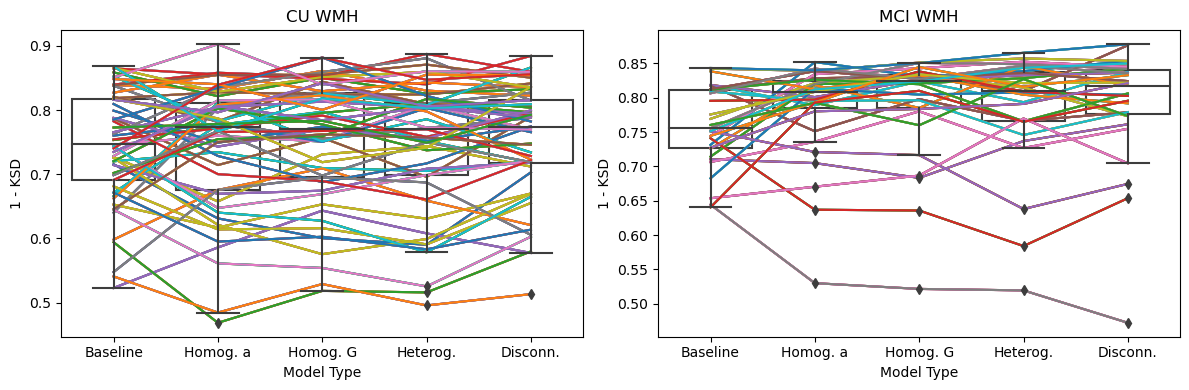

In [ ]:
def plot_spaghetti(df, groupname, ax):
    dict_group = {
        "All": "All",
        "CN_WMH": "CU WMH",
        "MCI_WMH": "MCI WMH",
    }
    list_a = []
    list_b = []
    list_g = []
    list_h = []
    list_d = []

    for pt in df["PTID"]:
        b = df[(df["PTID"] == pt) & (df["model_type"] == "baseline")]["phfcd_ks"]
        a = df[(df["PTID"] == pt) & (df["model_type"] == "homogeneous_a")]["phfcd_ks"]
        g = df[(df["PTID"] == pt) & (df["model_type"] == "homogeneous_G")]["phfcd_ks"]
        h = df[(df["PTID"] == pt) & (df["model_type"] == "heterogeneous")]["phfcd_ks"]
        d = df[(df["PTID"] == pt) & (df["model_type"] == "disconnectivity")]["phfcd_ks"]

        list_a.append(a)
        list_b.append(b)
        list_g.append(g)
        list_h.append(h)
        list_d.append(d)

    for i in range(len(df["PTID"])):
        ax.plot(np.arange(5), [list_b[i], list_a[i], list_g[i], list_h[i], list_d[i]])
    # Adjust the alpha (transparency) as needed
    boxprops = dict(facecolor="white")
    # Create the boxplot with specified alpha
    sns.boxplot(data=df, x="model_type", y="phfcd_ks", boxprops=boxprops, ax=ax)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["Baseline", "Homog. a", "Homog. G", "Heterog.", "Disconn."])
    ax.set_ylabel("1 - KSD")
    ax.set_xlabel("Model Type")

    ax.set_title(dict_group[groupname])


def find_worst(df_boxplot_compare, how_many):
    list_worst = []
    df_g = df_boxplot_compare[df_boxplot_compare["model_type"] == "homogeneous_G"].copy()
    for i in range(how_many):
        #worst = df_boxplot_compare[(df_boxplot_compare["model_type"] == "homogeneous_G") & (df_boxplot_compare["phfcd_ks"] == df_boxplot_compare["phfcd_ks"].min())]["PTID"].values[0]
        worst = df_g[df_g["phfcd_ks"] == df_g["phfcd_ks"].min()]["PTID"].values[0]
        # df_boxplot_compare = df_boxplot_compare[df_boxplot_compare["PTID"] != worst]
        df_g = df_g[df_g["PTID"] != worst]
        list_worst.append(worst)
    return list_worst


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plot_spaghetti(df_boxplot_compare_cn, "CN_WMH", axs[0])
plot_spaghetti(df_boxplot_compare_mci, "MCI_WMH", axs[1])
fig.tight_layout()
worsts = find_worst(df_boxplot_compare_mci, 1)

In [ ]:
# from scipy.stats import mannwhitneyu

# df_max = df_max_phfcd_G.copy()
# df_sub = df_max[df_max["model_type"] == "homogeneous_G"][["w", "wmh_load", "PTID"]]
# df_sub['cluster'] = np.where(df_sub["w"]< -0.5, 0, 1)
# df_petTOAD_mci = df_petTOAD[df_petTOAD["Group_bin_Fazekas"] == "MCI_WMH"]
# df_petTOAD_prova = pd.merge(df_petTOAD_mci, df_sub[["PTID", "cluster", "w", "wmh_load"]], on = "PTID")
# name_y = "WMH_load_subj_space"
# x = df_petTOAD_prova[df_petTOAD_prova["cluster"] == 0][name_y]
# y = df_petTOAD_prova[df_petTOAD_prova["cluster"] == 1][name_y]
# print(mannwhitneyu(x, y))
# fig, axs = plt.subplots(1,2, figsize = (10, 5))
# axs[0].scatter(df_petTOAD_prova["wmh_load"], df_petTOAD_prova["w"], c=df_petTOAD_prova["cluster"])
# sns.boxplot(data = df_petTOAD_prova, x = "cluster", y = "WMH_load_subj_space", ax = axs[1])
# fig.tight_layout()
# plt.figure()
# sns.regplot(data = df_petTOAD_prova, x = "wmh_load", y = "w", order = 1)


In [ ]:
# def plot_distribution_phfcd_outlier_vs_normal(worsts):
#     list_emp_phfcd_normal = []
#     list_emp_phfcd_not_normal = []

#     for subj in MCI_WMH:
#         emp_data = np.load(G_DIR / f"group-single-subj-{subj}_data-empirical_model-homogeneous_G_desc-fc-phfcd-arr.npz")
#         if subj not in worsts:
#             list_emp_phfcd_normal.append(emp_data["emp_phfcd"])
#         else:
#             list_emp_phfcd_not_normal.append(emp_data["emp_phfcd"])

#     # Flatten the arrays after the loop
#     normal = np.array(list_emp_phfcd_normal).flatten()
#     not_normal = np.array(list_emp_phfcd_not_normal).flatten()
#     plt.hist(normal, bins=101, edgecolor='black', alpha=0.7, label='Good fit', density=True, weights=np.ones_like(normal) / len(normal) * 100)
#     plt.hist(not_normal, bins=101, edgecolor='black', alpha=0.7, label='Bad fit', density=True, weights=np.ones_like(not_normal) / len(not_normal) * 100)
#     plt.xlabel('phFCD')
#     plt.ylabel('Percentage of Occurrence')
#     plt.title('phFCD distribution in MCI WMH')
#     plt.legend()
#     plt.show()
# plot_distribution_phfcd_outlier_vs_normal(worsts)
# df_bad = pd.DataFrame(data = worsts, columns = ["PTID"])
# df_bad.to_csv(SIM_DIR / "outlier_bad_fitting.csv")

In [ ]:
# n_times = 10000 #low for testing
# groups = ["All"] # "CN_WMH", "MCI_WMH"]
# models = ["homogeneous_G"] # "homogeneous_a", "heterogeneous"]
# dict_df_big = {
#     "homogeneous_a": {"df_big": df_a_big, "ws":ws_a},
#     "homogeneous_G": {"df_big": df_G_big, "ws":ws_G},
#     "heterogeneous": {"df_big": df_het_big, "ws":ws_het},
# }
# for group in groups:
#     for model in models:
#         if group == "All":
#             list_best_bs = []
#             list_best_ws = []
#             for i in range(n_times):
#                 df_big_subset = dict_df_big[model]["df_big"].sample(n=len(dict_df_big[model]["df_big"]), replace=True)
#                 best_b, best_w, _ = find_best_b_w_group(group, model, df_big_subset)
#                 list_best_bs.append(best_b)
#                 list_best_ws.append(best_w)
#             confidence_interval = np.percentile(list_best_bs, [2.5, 97.5])
#             freq, values = np.histogram(list_best_bs, bins = dict_df_big[model]["ws"])
#             best_b_all_boot = round(values[np.argmax(freq)], 3)
#             print(best_b_all_boot, confidence_interval)
#             # Check if the confidence interval excludes zero
#             if confidence_interval[1] < 0:
#                 print("The values are significantly below zero.")
#             else:
#                 print("There is no significant evidence that the values are below zero.")
#             plt.hist(list_best_bs)
#             plt.title(f"All {model} b")
#         else:
#             list_best_bs = []
#             list_best_ws = []
#             for i in range(n_times):
#                 df_big_subset = dict_df_big[model].sample(n=len(dict_df_big[model]), replace=True)
#                 best_b, best_w, _ = find_best_b_w_group(
#                     group, model, df_big_subset, best_b_all=best_b_all_boot
#                 )
#                 list_best_bs.append(best_b)
#                 list_best_ws.append(best_w)

In [ ]:
# plt.hist(list_best_ws, bins = 21);

In [ ]:
# # Create a JointGrid for the scatter plots and histograms
# grid1 = sns.JointGrid(height=6, ratio=3)

# # Plot the scatter plots on the grid
# sns.regplot(
#     data=df_max_comp_score_a_cn, x="wmh_load", y="a", ax=grid1.ax_joint, label="CU WMH"
# )
# sns.regplot(
#     data=df_max_comp_score_a_mci,
#     x="wmh_load",
#     y="a",
#     ax=grid1.ax_joint,
#     label="MCI WMH",
# )

# # Plot histograms on the top and left sides of the grid
# sns.histplot(data=df_max_comp_score_a_cn, x="wmh_load", ax=grid1.ax_marg_x, kde=True)
# sns.histplot(
#     data=df_max_comp_score_a_mci,
#     x="wmh_load",
#     ax=grid1.ax_marg_x,
#     kde=True,
#     color="tab:orange",
# )
# sns.histplot(data=df_max_comp_score_a_cn, y="a", ax=grid1.ax_marg_y, kde=True)
# sns.histplot(
#     data=df_max_comp_score_a_mci,
#     y="a",
#     ax=grid1.ax_marg_y,
#     kde=True,
#     color="tab:orange",
# )

# # Set labels for the scatter plot and legends
# grid1.set_axis_labels(
#     "Normalized WMH volume", "Bifurcation parameter (a)", fontsize=9.5
# )
# grid1.ax_joint.legend()
# ax1 = grid1.fig.axes[0]
# ax1.text(-0.1, 1.1, "A", transform=ax1.transAxes, size=20, weight="bold")


# # Create a JointGrid for the scatter plots and histograms
# grid2 = sns.JointGrid(height=6.2, ratio=3)

# # Plot the scatter plots on the grid
# sns.regplot(
#     data=df_max_comp_score_G_cn, x="wmh_load", y="G", ax=grid2.ax_joint, label="CU WMH"
# )
# sns.regplot(
#     data=df_max_comp_score_G_mci,
#     x="wmh_load",
#     y="G",
#     ax=grid2.ax_joint,
#     label="MCI WMH",
# )

# # Plot histograms on the top and left sides of the grid
# sns.histplot(data=df_max_comp_score_G_cn, x="wmh_load", ax=grid2.ax_marg_x, kde=True)
# sns.histplot(
#     data=df_max_comp_score_G_mci,
#     x="wmh_load",
#     ax=grid2.ax_marg_x,
#     kde=True,
#     color="tab:orange",
# )
# sns.histplot(data=df_max_comp_score_G_cn, y="G", ax=grid2.ax_marg_y, kde=True)
# sns.histplot(
#     data=df_max_comp_score_G_mci,
#     y="G",
#     ax=grid2.ax_marg_y,
#     kde=True,
#     color="tab:orange",
# )

# # Set labels for the scatter plot and legends
# grid2.set_axis_labels("Normalized WMH volume", "Global coupling (G)", fontsize=10)
# grid2.ax_joint.legend()
# ax2 = grid2.fig.axes[0]
# ax2.text(-0.1, 1.1, "B", transform=ax2.transAxes, size=22, weight="bold")